In [1]:
import os
import numpy as np
import emphases
import pypar

In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T


In [3]:
s3_audio = emphases.load.audio('../data/cache/buckeye/wavs/s03-1.wav')
s11_audio = emphases.load.audio('../data/cache/buckeye/wavs/s11-1.wav')

s32_audio = emphases.load.audio('../data/cache/buckeye/wavs/s32-1.wav')


In [4]:
s32_audio.shape

torch.Size([1, 304455])

#### Get Mel

In [5]:
n_fft = 1024
win_length = 1024
hop_length = 160
n_mels = 80

mel_spectrogram = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [6]:
s3_audio.shape

torch.Size([1, 346223])

In [7]:
346223//160

2163

In [8]:
melspec = mel_spectrogram(s3_audio)
melspec.shape

torch.Size([1, 80, 2164])

In [9]:
melspec_s11 = mel_spectrogram(s11_audio)
melspec_s11.shape

torch.Size([1, 80, 2404])

In [10]:
melspec_s32 = mel_spectrogram(s32_audio)
melspec_s32.shape

torch.Size([1, 80, 1903])

In [11]:
s11_audio.shape[-1]/160.4

2397.2568578553614

#### Get prom and alignment

In [12]:
# alignment = pypar.Alignment('../data/cache/buckeye/alignment/s03-1.json')

alignment = pypar.Alignment('../data/cache/buckeye/alignment/s32-1.json')
word_bounds = alignment.word_bounds(emphases.SAMPLE_RATE, emphases.HOPSIZE)

# prominence = emphases.load.prominence('../data/cache/buckeye/annotation/s03-1.prom')
prominence = emphases.load.prominence('../data/cache/buckeye/annotation/s32-1.prom')

In [13]:
melspec_s32.shape

torch.Size([1, 80, 1903])

In [14]:
prominence, prominence.shape

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1562, 0.2812, 0.3125,
         0.0312, 0.0000, 0.8125, 0.3750, 0.0938, 0.0000, 0.0000, 0.0625, 0.0000,
         0.0000, 0.1562, 0.0312, 0.0000, 0.0312, 0.5625, 0.1562, 0.3125, 0.3750,
         0.0000, 0.0000, 0.0312, 0.0000, 0.0000, 0.0312, 0.0000, 0.5625, 0.5312,
         0.0000, 0.0000, 0.0000, 0.9062, 0.0312, 0.1250, 0.0000, 0.0000, 0.0000,
         0.9062, 0.0312, 0.3750, 0.0938, 0.0938, 0.8750, 0.0312, 0.0000, 0.4062,
         0.0000, 0.0000, 0.0000, 0.1250, 0.1250, 0.0000, 0.0000, 0.0312, 0.0000,
         0.0938, 0.0000, 0.5312, 0.3125]),
 torch.Size([67]))

In [15]:
word_bounds

[(13, 27),
 (27, 33),
 (33, 47),
 (47, 52),
 (52, 61),
 (61, 68),
 (68, 90),
 (90, 139),
 (139, 181),
 (181, 209),
 (209, 239),
 (239, 275),
 (275, 284),
 (284, 317),
 (317, 325),
 (325, 342),
 (342, 362),
 (362, 395),
 (395, 404),
 (404, 419),
 (419, 432),
 (432, 451),
 (451, 477),
 (477, 529),
 (529, 571),
 (577, 595),
 (595, 654),
 (739, 779),
 (807, 820),
 (820, 840),
 (840, 855),
 (855, 884),
 (884, 906),
 (906, 917),
 (917, 940),
 (940, 976),
 (1002, 1030),
 (1030, 1042),
 (1042, 1068),
 (1068, 1102),
 (1102, 1111),
 (1111, 1165),
 (1165, 1189),
 (1189, 1200),
 (1226, 1239),
 (1239, 1274),
 (1274, 1287),
 (1287, 1313),
 (1504, 1510),
 (1510, 1522),
 (1522, 1570),
 (1642, 1644),
 (1644, 1657),
 (1657, 1674),
 (1674, 1677),
 (1677, 1686),
 (1686, 1694),
 (1694, 1713),
 (1713, 1739),
 (1739, 1745),
 (1745, 1750),
 (1750, 1774),
 (1774, 1787),
 (1787, 1810),
 (1810, 1815),
 (1815, 1837),
 (1837, 1869)]

### Interpolate

#### Prepare grid

In [16]:
# audio_len = s3_audio.shape[-1]
audio_len = s32_audio.shape[-1]
audio_len

304455

In [17]:
# # this is a sample function to create constant ratio grid
# def constant(tensor, ratio):
#     """Create a grid for constant-ratio time-stretching"""
#     return torch.linspace(
#         0.,
#         tensor.shape[-1] - 1,
# #         round((tensor.shape[-1]) / ratio + 1e-4),
#         round((tensor.shape[-1]) / (ratio)),
#         dtype=torch.float,
#         device=tensor.device)

In [18]:
# grid = constant(s3_audio, 160.4)
# grid, grid[-1]

In [19]:
def grid_sample(sequence, grid, method='linear'):
    """Perform 1D grid-based sampling"""
    # Require interpolation method to be defined
    if method not in ['linear', 'nearest']:
        raise ValueError(
            f'Interpolation mode {emphases.PPG_INTERP_METHOD} is not defined')

    # Setup grid parameters
    x = grid
    fp = sequence

    # Linear grid interpolation
    if method == 'linear':
        xp = torch.arange(sequence.shape[-1], device=sequence.device)
        i = torch.clip(torch.searchsorted(xp, x, right=True), 1, len(xp) - 1)
        return (
            (fp[..., i - 1] * (xp[i] - x) + fp[..., i] * (x - xp[i - 1])) /
            (xp[i] - xp[i - 1]))

    # Nearest neighbors grid interpolation
    elif method == 'nearest':
        return fp[..., torch.round(x).to(torch.long)]

    else:
        raise ValueError(f'Grid sampling method {method} is not defined')


In [20]:
# interpolated_val = grid_sample(prominence, grid)
# xp = torch.arange(prominence.shape[-1], device=prominence.device)
# i = torch.clip(torch.searchsorted(xp, grid, right=True), 1, len(xp) - 1)

#### Using Numpy

In [21]:
# s3_audio.shape

# 19*160 - 0

# s3_audio.shape[-1] - 2149*160

# 346223//160, 346223/160

# 346080//160, 346080/160

In [23]:
def nearest_neighbour_interpolation(audio, word_bounds, prominence):
    wb_prom_pairs = []
    audio_len = audio.shape[-1]

    if word_bounds[0][0]!=0:
        wb_prom_pairs.append([(0, word_bounds[0][0]), 0])

    for idx in range(len(word_bounds)):
        wb_prom_pairs.append([word_bounds[idx], prominence[idx].item()])
        if idx+1<len(word_bounds):
            if word_bounds[idx][-1]!=word_bounds[idx+1][0]:
                start = word_bounds[idx][-1]
                end = word_bounds[idx+1][0]
                wb_prom_pairs.append([(start, end), 0])
                
    prom_extended = []

    for wb in wb_prom_pairs:
        start, end = wb[0][0], wb[0][1]
        # prom_extended.extend([wb[-1]]*(end-start)*160)
        prom_extended.extend([wb[-1]]*(end-start))

    if word_bounds[-1][-1]!=(audio_len//160 + 1):
        pad_len = (audio_len//160 + 1) - len(prom_extended)
        prom_extended.extend([0]*pad_len)

    prom_extended = torch.tensor(prom_extended)
    
    return prom_extended

In [24]:
# alignment = pypar.Alignment('../data/cache/buckeye/alignment/s03-1.json')
# alignment = pypar.Alignment('../data/cache/buckeye/alignment/s32-1.json')
alignment = pypar.Alignment('../data/cache/buckeye/alignment/s11-1.json')

word_bounds = alignment.word_bounds(emphases.SAMPLE_RATE, emphases.HOPSIZE)

# prominence = emphases.load.prominence('../data/cache/buckeye/annotation/s03-1.prom')
# prominence = emphases.load.prominence('../data/cache/buckeye/annotation/s32-1.prom')
prominence = emphases.load.prominence('../data/cache/buckeye/annotation/s11-1.prom')

In [47]:
nearest_neighbour_interpolation(s11_audio, word_bounds, prominence).shape

torch.Size([2404])

In [27]:
melspec.shape

torch.Size([1, 80, 2164])

In [28]:
melspec_s32.shape

torch.Size([1, 80, 1903])

In [29]:
melspec_s11.shape

torch.Size([1, 80, 2404])

### Linear Interpolation

In [30]:
# audio = emphases.load.audio('../data/cache/buckeye/wavs/s32-1.wav')
audio = emphases.load.audio('../data/cache/buckeye/wavs/s11-1.wav')

# alignment = pypar.Alignment('../data/cache/buckeye/alignment/s03-1.json')
# alignment = pypar.Alignment('../data/cache/buckeye/alignment/s32-1.json')
alignment = pypar.Alignment('../data/cache/buckeye/alignment/s11-1.json')

word_bounds = alignment.word_bounds(emphases.SAMPLE_RATE, emphases.HOPSIZE)

# prominence = emphases.load.prominence('../data/cache/buckeye/annotation/s03-1.prom')
# prominence = emphases.load.prominence('../data/cache/buckeye/annotation/s32-1.prom')
prominence = emphases.load.prominence('../data/cache/buckeye/annotation/s11-1.prom')

In [40]:
prominence, prominence.shape

(tensor([0.0000, 0.2500, 0.0938, 0.7812, 0.2188, 0.1875, 0.0000, 0.0000, 0.0312,
         0.4062, 0.5625, 0.0000, 0.0625, 0.0625, 0.0312, 0.0625, 0.4688, 0.6875,
         0.1562, 0.0000, 0.4062, 0.0000, 0.0938, 0.0312, 0.4062, 0.0000, 0.3438,
         0.1875, 0.6250, 0.2188, 0.1250, 0.0000, 0.5000, 0.1875, 0.0000, 0.0000,
         0.0938, 0.1250, 0.4062, 0.5000, 0.0312, 0.7500, 0.0312, 0.0312, 0.3125,
         0.0000, 0.0312, 0.1250, 0.1562, 0.0625, 0.0938, 0.1562]),
 torch.Size([52]))

In [34]:
# wb_idx_prom_pairs = []
# audio_len = audio.shape[-1]

# # if word_bounds[0][0]!=0:
# #     wb_idx_prom_pairs.append([0, 0])
# #     wb_idx_prom_pairs.append([word_bounds[0][0], 0])

# for idx in range(1, len(word_bounds)):
#     # wb_prom_pairs.append([word_bounds[idx], prominence[idx].item()])
#     wb_idx_prom_pairs.append([word_bounds[idx][0], prominence[idx-1].item()])
#     wb_idx_prom_pairs.append([word_bounds[idx][1], prominence[idx].item()])

#     if idx+1<len(word_bounds):
#         if word_bounds[idx][-1]!=word_bounds[idx+1][0]:
#             start = word_bounds[idx][-1]
#             end = word_bounds[idx+1][0]
#             # wb_prom_pairs.append([(start, end), 0])
#             wb_idx_prom_pairs.append([start, prominence[idx-1].item()])
#             wb_idx_prom_pairs.append([end, prominence[idx+1].item()])


# # prom_extended = []

# # for wb in wb_prom_pairs:
# #     start, end = wb[0][0], wb[0][1]
# #     # prom_extended.extend([wb[-1]]*(end-start)*160)
# #     prom_extended.extend([wb[-1]]*(end-start))

# # if word_bounds[-1][-1]!=(audio_len//160 + 1):
# #     pad_len = (audio_len//160 + 1) - len(prom_extended)
# #     prom_extended.extend([0]*pad_len)

# # prom_extended = torch.tensor(prom_extended)


### Interpolation Corrected

In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [74]:
def interpolate_numpy(sequence, positions, pred_grid):
    fp = sequence
    xp = positions
    return torch.tensor(np.interp(pred_grid, xp, fp))

In [97]:
def linear_interp(audio, word_bounds, prominence):
    positions = []
    for bound in word_bounds:
        mid = (bound[0] + bound [1])//2
        positions.append(mid)
    
    audio_len = audio.shape[-1]
    pred_grid = list(range(0, audio_len//160 + 1))
    interp_prom = interpolate_numpy(prominence, positions, pred_grid)
    return interp_prom

In [98]:
interp_prom = linear_interp(audio, word_bounds, prominence)
interp_prom.shape

torch.Size([2404])

In [102]:
melspec_s11.shape

torch.Size([1, 80, 2404])

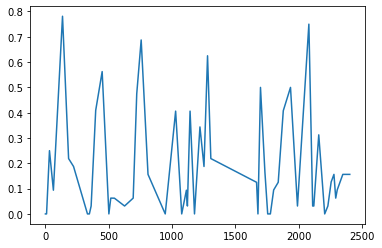

In [103]:
plt.plot(interp_prom.cpu().numpy())